In [725]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date,datetime,timedelta
from scipy.spatial.distance import cdist
from sklearn import cluster
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
%matplotlib inline

# Data preperation

In [726]:
#read in whole data excluding Linz csv file :
df = pd.read_csv("/Users/tamo/Documents/Studium/WS 20-21/Master thesis/Data/Intelliekon/consumption_loadcourse_excl_Linz.csv")
#read in only Ulm data csv file:
#df = pd.read_csv("/Users/tamo/Documents/Studium/WS 20-21/Master thesis/Data/Intelliekon/consumption_loadcurse_Ulm.csv")

/Users/tamo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [727]:
df.head()

,datetime,ID,Fall_ge1,IdCons,Datum,Hour_of_Year,Season,Weekday,Hour_of_Day,Fehlerfeld,Daten_Herkunft,Electricity_Demand,dateyear
0,2009-10-06 01:00:00,1,636,391943,6/10/2009,6673,0,1,1,0,Münster,215.0,2009
1,2009-10-07 01:00:00,2,636,391943,7/10/2009,6697,0,1,1,0,Münster,196.0,2009
2,2009-10-08 01:00:00,3,636,391943,8/10/2009,6721,0,1,1,0,Münster,235.0,2009
3,2009-10-09 01:00:00,4,636,391943,9/10/2009,6745,0,1,1,0,Münster,250.0,2009
4,2009-10-10 01:00:00,5,636,391943,10/10/2009,6769,0,2,1,0,Münster,288.0,2009


In [728]:
df["Daten_Herkunft"].unique()

array(['Münster', 'Kaiserslautern', 'Ulm', 'Krefeld', 'Schwerte',
       'Hassfurt', 'Celle'], dtype=object)

In [729]:
#Split df to certain location
#df = df[df["Daten_Herkunft"]=="Schwerte"]
#Liste mit Fall_ge to connect results with survey data
id_lst = list(df["Fall_ge1"].unique())

In [730]:
#exclude fall_ge1 = 143 and 104 (outliers for location: "Schwerte")
#df = df[df["Fall_ge1"] != 143]
#df = df[df["Fall_ge1"] != 104]

In [731]:
df["Fall_ge1"].nunique()

600

In [732]:
#convert to datetime format and ad new "date" and "hour"-column in datetime format

df["datetime"] = pd.to_datetime(df["Datum"],dayfirst = True) + df["Hour_of_Day"].astype("timedelta64[h]")
df.datetime.dt.tz_localize("UTC").dt.tz_convert("Europe/Berlin")

#df["date"]= df['datetime'].apply(lambda x: x.date)
df["day_of_year"] = df["datetime"].apply(lambda x: x.timetuple().tm_yday)
df["hour"]= df['datetime'].apply(lambda x: x.hour)
df.head()


,datetime,ID,Fall_ge1,IdCons,Datum,Hour_of_Year,Season,Weekday,Hour_of_Day,Fehlerfeld,Daten_Herkunft,Electricity_Demand,dateyear,day_of_year,hour
0,2009-10-06 01:00:00,1,636,391943,6/10/2009,6673,0,1,1,0,Münster,215.0,2009,279,1
1,2009-10-07 01:00:00,2,636,391943,7/10/2009,6697,0,1,1,0,Münster,196.0,2009,280,1
2,2009-10-08 01:00:00,3,636,391943,8/10/2009,6721,0,1,1,0,Münster,235.0,2009,281,1
3,2009-10-09 01:00:00,4,636,391943,9/10/2009,6745,0,1,1,0,Münster,250.0,2009,282,1
4,2009-10-10 01:00:00,5,636,391943,10/10/2009,6769,0,2,1,0,Münster,288.0,2009,283,1


In [733]:
#normalisation:
df['max_energy'] = df.groupby(['Fall_ge1'])['Electricity_Demand'].transform(max)
df['norm_energy'] = df['Electricity_Demand'] / df['max_energy']

In [734]:
#Meteorological seasons:
#winter
sdate_wi = date(2009, 12, 1)   # start date
edate_wi = date(2010, 2, 28)   # end date
#spring
sdate_sp = date(2010, 3, 1)   # start date
edate_sp = date(2010, 5, 31)   # end date
#summer
sdate_su = date(2010, 6, 1)   # start date
edate_su = date(2010, 8, 31)   # end date
#Fall
sdate_fa = date(2009, 9, 1)   # start date
edate_fa = date(2009, 11, 30)   # end date

In [735]:
#filter df by season:
df_fa = df[(df["datetime"] > str(sdate_fa)) & (df["datetime"] <= str(edate_fa))]
df_wi = df[(df["datetime"] > str(sdate_wi)) & (df["datetime"] <= str(edate_wi))]
df_sp = df[(df["datetime"] > str(sdate_sp)) & (df["datetime"] <= str(edate_sp))]
df_su = df[(df["datetime"] > str(sdate_su)) & (df["datetime"] <= str(edate_su))]

In [736]:
df_sp.shape

(1029672, 17)

In [737]:
df_su.shape

(1071120, 17)

In [738]:
df_wi.shape

(933480, 17)

In [739]:
df_fa.shape

(929712, 17)

In [740]:
#split dataframes into weekday and weekend days
df_fa_week=df_fa[df_fa["Weekday"]==1]
df_fa_wknd=df_fa[df_fa["Weekday"]==2]
df_wi_week=df_wi[df_wi["Weekday"]==1]
df_wi_wknd=df_wi[df_wi["Weekday"]==2]
df_sp_week=df_sp[df_sp["Weekday"]==1]
df_sp_wknd=df_sp[df_sp["Weekday"]==2]
df_su_week=df_su[df_su["Weekday"]==1]
df_su_wknd=df_su[df_su["Weekday"]==2]

In [741]:
df.set_index("datetime", inplace = True)

# Functions for clustering

In [742]:
def elbow_method(dataframe, min_k, max_k):
    # Try all k's between min_k and max_k
    cluster_nums = range(min_k, max_k + 1)
    
    # Array of K-means algorithm objects
    k_mean_algs = [cluster.KMeans(n_clusters = k) for k in cluster_nums]
    
    # Array with the results of the K-mean algorithms
    k_mean_res = [alg.fit(dataframe) for alg in k_mean_algs]
    
    # Array with the centroids for each value of k
    centroids = [res.cluster_centers_ for res in k_mean_res]
    
    # Euclidean distance between the points of the cluster and the centroids
    distances = [cdist(dataframe, centroid, 'euclidean') for centroid in centroids]
    
    # Get the closest centroid (and the corresponding distance)
    min_indices = [np.argmin(distance, axis = 1) for distance in distances]
    min_distances = [np.min(distance, axis = 1) for distance in distances]
    
    # Calculate the average squared distance
    avg_sum_squares = [sum(dist ** 2) / kmeans_df.shape[0] for dist in min_distances]

    # Plot the elbow graph
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(cluster_nums, avg_sum_squares, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average sum of squares within cluster')
    plt.show()
    
    return (k_mean_algs, k_mean_res) 
    #return distances

In [743]:
#multiline plot:
def multiline_hourly_plot(dataset, avg = None, ycol = 'Electricity_Demand', ymin = None, ymax = None, opacity = None, title = None):
    fig, ax = plt.subplots()
    
    if ymin is not None:
        ax.set_ylim(bottom = ymin)
    
    if ymax is not None:
        ax.set_ylim(top = ymax)
        
    if opacity is None:
        opacity = 0.01

    for key, group in dataset:
        ax = group.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#000000', alpha = opacity)
    
    if avg is not None:
        ax = avg.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#FF0000', alpha = 1, linewidth = 2)
        
    if title is not None:
        ax.set_title(title)

    ax.legend().set_visible(False) # Disable the plot legend
    plt.show()
    
    return fig

In [744]:
def clusters_visualisation(grp_df, id_vars, value_vars):
    melt_df = pd.melt(kmeans_df, id_vars = id_vars, value_vars = value_vars, var_name = 'hour', value_name = 'norm_energy')
    clusters = grp_df['cluster'].unique()
    clusters.sort()
    for c in clusters:
        avg = melt_df[melt_df.cluster == c]
        data = avg.groupby(id_vars)
        multiline_hourly_plot(data, avg = avg, ymin = 0, ycol = 'norm_energy', opacity = 0.1, title = 'Cluster ' + str(c))

In [745]:
#def plot_clustering_results()

In [746]:
#def cluster_overview(cluster_centers)
#    sort
#    plt.plot(fall_week[x],label="Cluster " + str(x + 1))

In [747]:
# for x in range(0,5,1):
#     plt.plot(fall_week[x],label="Cluster " + str(x + 1))
# plt.legend()
# plt.title("Fall weekdays")
# plt.ylabel("normalized consumption")
# plt.xlabel("hour")

# Fall

### Fall weekday 

In [748]:
red_df=df_fa_week[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#check if cluster column is in kmeans_df and delet it: (Avoiding error with too many parameters for clustering algorithm)
if "cluster" in kmeans_df:
    del kmeans_df["cluster"]

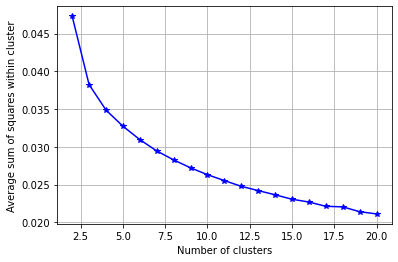

In [749]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [750]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 5 corresponds to the element with index 3
clustering = k_res[3]

In [751]:
#reassign cluster numbers so the cluster numbers are from lowest to highest mean
k=5
#order of clustering centers by mean (idx)
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
#"key" to convert count from 1 to 5 to the order regarding the mean (lut)
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [752]:
idx

array([3, 1, 0, 4, 2])

In [753]:
#assign cluster labels odered by mean to dataframe
kmeans_df['cluster'] = list(lut[clustering.labels_])

In [754]:
#createdataframe with cluster number and ID
cluster_df = pd.DataFrame(index = kmeans_df.index)

In [755]:
#assign cluster membership to column of cluster_df
cluster_df["cluster_fa_week"] = kmeans_df['cluster']

In [756]:
#order clustering centers by mean
clust_cent = clustering.cluster_centers_[idx]

Text(0.5, 0, 'hour')

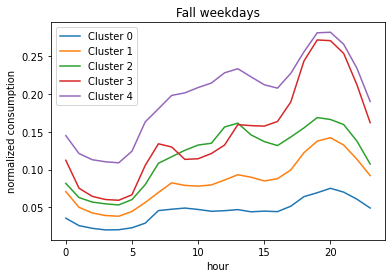

In [757]:
for x in range(0,5,1):
    plt.plot(clust_cent[x],label = "Cluster " + str(x))  
plt.legend()
plt.title("Fall weekdays")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

In [758]:
#function for cluster validation scores
def cluster_validation(df,clustering):
    labels = clustering.labels_
    sil_coef = metrics.silhouette_score(df, labels, metric='euclidean')
    cal_har = metrics.calinski_harabasz_score(df, labels)
    db_ind = metrics.davies_bouldin_score(df, labels)
    coef_df = pd.DataFrame([[sil_coef,cal_har,db_ind]], columns = ["Silhouette","Calinski-Harabasz","Davies-Bouldin"])
    return coef_df

In [759]:
clust_coef = pd.DataFrame(columns = ["Silhouette","Calinski-Harabasz","Davies-Bouldin"])
clust_coef = clust_coef.append(cluster_validation(kmeans_df,clustering),ignore_index = True)
clust_coef

,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,0.77257,5321.440256,0.381114


In [760]:
kmeans_df[kmeans_df["cluster"]==4]

hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,cluster
Fall_ge1,,,,,,,,,,,,,,,,,,,,,
13,0.194975,0.187350,0.185809,0.187204,0.187616,0.212004,0.220795,0.294712,0.322746,0.345115,...,0.298472,0.301187,0.274252,0.263036,0.248419,0.261428,0.246303,0.227137,0.221218,4
22,0.100366,0.083807,0.088025,0.081968,0.086748,0.082827,0.087393,0.094932,0.124473,0.177174,...,0.237604,0.255352,0.193663,0.238672,0.239861,0.284708,0.212796,0.167229,0.127116,4
104,0.244747,0.218493,0.211883,0.207341,0.205384,0.209261,0.212252,0.216462,0.235553,0.186256,...,0.196448,0.195229,0.206824,0.233743,0.240833,0.286142,0.291274,0.288099,0.251542,4
178,0.094279,0.067798,0.056322,0.055318,0.055942,0.054760,0.097003,0.084560,0.093341,0.091320,...,0.301819,0.282363,0.291182,0.324283,0.327469,0.308861,0.313435,0.319419,0.211771,4
244,0.246085,0.262823,0.249234,0.245809,0.211739,0.181704,0.173973,0.236484,0.212568,0.164736,...,0.164507,0.171982,0.182303,0.209576,0.235608,0.236421,0.242796,0.243057,0.236645,4
269,0.200165,0.175732,0.171004,0.173625,0.184344,0.176949,0.189166,0.237300,0.297666,0.333489,...,0.246895,0.277336,0.282001,0.263169,0.258831,0.264760,0.251077,0.211618,0.213443,4
317,0.094062,0.088517,0.088182,0.088796,0.088145,0.087084,0.112949,0.211366,0.216297,0.271971,...,0.138479,0.118327,0.123072,0.204146,0.318063,0.311792,0.292365,0.287937,0.239017,4
374,0.131985,0.095732,0.088558,0.083312,0.082785,0.085339,0.116228,0.133267,0.149110,0.148497,...,0.269577,0.259621,0.467516,0.295324,0.243028,0.260955,0.244547,0.206495,0.196292,4
480,0.135073,0.115461,0.115369,0.115873,0.116270,0.122451,0.156212,0.201679,0.271566,0.251419,...,0.245177,0.262790,0.283700,0.405250,0.405769,0.402030,0.408074,0.319918,0.199847,4


### Fall weekend 

In [761]:
red_df=df_fa_wknd[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df

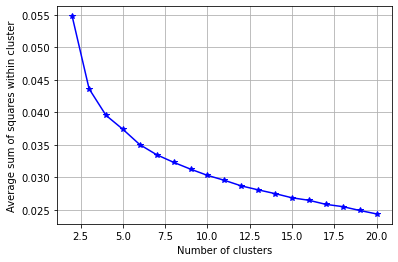

In [762]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [763]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [764]:
k=5
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [765]:
#assign cluster labels odered by mean to dataframe
kmeans_df['cluster'] = list(lut[clustering.labels_])

In [766]:
#assign cluster membership to column of cluster_df
cluster_df["cluster_fa_wknd"] = kmeans_df['cluster']

In [767]:
#order clustering centers by mean
clust_cent = clustering.cluster_centers_[idx]

Text(0.5, 0, 'hour')

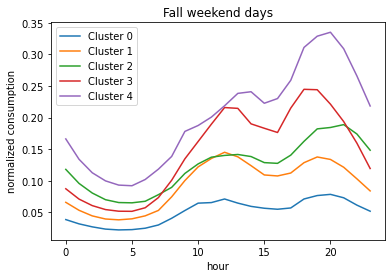

In [768]:
for x in range(0,5,1):
    plt.plot(clust_cent[x],label = "Cluster " + str(x))  
plt.legend()
plt.title("Fall weekend days")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

In [769]:
clust_coef = clust_coef.append(cluster_validation(kmeans_df,clustering),ignore_index = True)
clust_coef

,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,0.772570,5321.440256,0.381114
1,0.757771,5783.902924,0.402092


In [770]:
#kmeans_df['Fall_ge1'] = kmeans_df.index
#clusters_visualisation(kmeans_df, id_vars = ["Fall_ge1",'cluster'], value_vars = list(kmeans_df.columns[0:23]))

# Winter

### Winter weekdays

In [771]:
red_df=df_wi_week[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

In [772]:
kmeans_model = cluster.KMeans(n_clusters=5).fit(kmeans_df)
labels = kmeans_model.labels_
metrics.silhouette_score(kmeans_df, labels, metric='euclidean')

0.1780361399754565

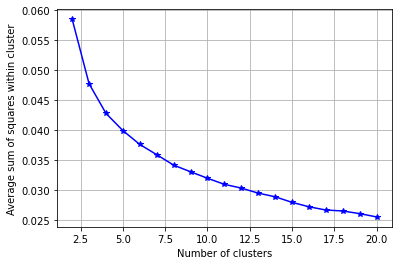

In [773]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [774]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [775]:
k=5
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [776]:
#assign cluster labels odered by mean to dataframe
kmeans_df['cluster'] = list(lut[clustering.labels_])

In [777]:
#assign cluster membership to column of cluster_df
cluster_df["cluster_wi_week"] = kmeans_df['cluster']

In [778]:
#order clustering centers by mean
clust_cent = clustering.cluster_centers_[idx]

Text(0.5, 0, 'hour')

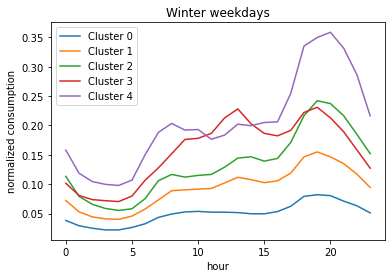

In [779]:
for x in range(0,5,1):
    plt.plot(clust_cent[x],label = "Cluster " + str(x))  
plt.legend()
plt.title("Winter weekdays")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

In [780]:
clust_coef = clust_coef.append(cluster_validation(kmeans_df,clustering),ignore_index = True)
clust_coef

,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,0.772570,5321.440256,0.381114
1,0.757771,5783.902924,0.402092
2,0.753033,5407.033738,0.406145


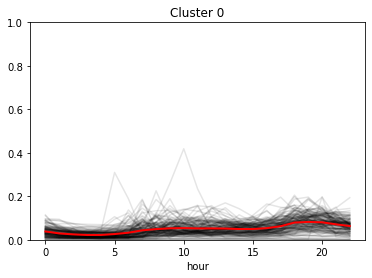

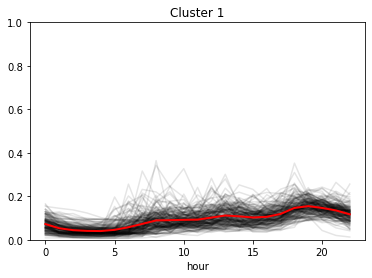

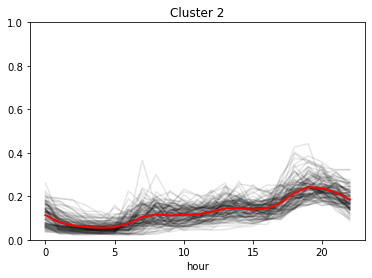

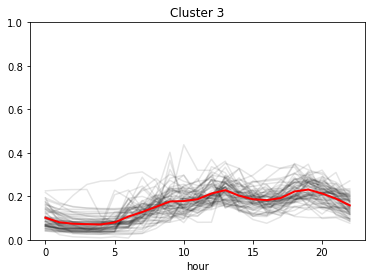

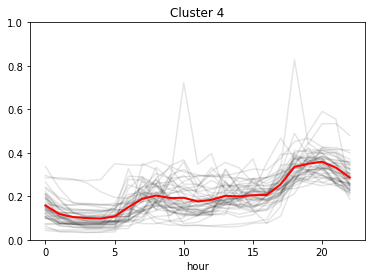

In [781]:
kmeans_df['Fall_ge1'] = kmeans_df.index
clusters_visualisation(kmeans_df, id_vars = ["Fall_ge1",'cluster'], value_vars = list(kmeans_df.columns[0:23]))
#plt.savefig('wknd_7_norm_year.png')

### Winter weekend days

In [782]:
red_df=df_wi_wknd[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

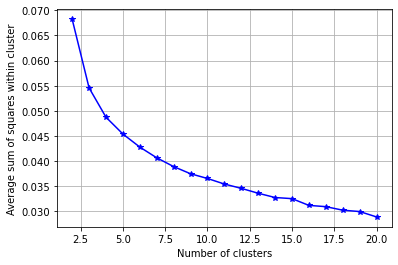

In [783]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [784]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [785]:
#reassign cluster numbers so the cluster numbers are from lowest to highest mean
k=5
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [786]:
#assign cluster labels odered by mean to dataframe
kmeans_df['cluster'] = list(lut[clustering.labels_])

In [787]:
#assign cluster membership to column of cluster_df
cluster_df["cluster_wi_wknd"] = kmeans_df['cluster']

In [788]:
#order clustering centers by mean
clust_cent = clustering.cluster_centers_[idx]

Text(0.5, 0, 'hour')

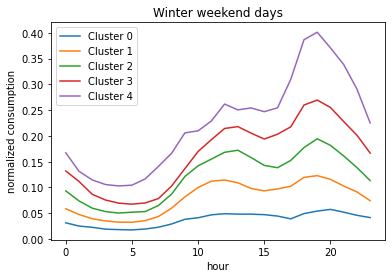

In [789]:
for x in range(0,5,1):
    plt.plot(clust_cent[x],label = "Cluster " + str(x))  
plt.legend()
plt.title("Winter weekend days")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

In [790]:
clust_coef = clust_coef.append(cluster_validation(kmeans_df,clustering),ignore_index = True)
clust_coef

,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,0.772570,5321.440256,0.381114
1,0.757771,5783.902924,0.402092
2,0.753033,5407.033738,0.406145
3,0.736585,4000.553603,0.422374


# Spring

### Spring weekdays

In [791]:
red_df=df_sp_week[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

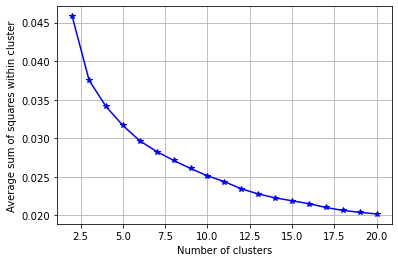

In [792]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [793]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [794]:
#reassign cluster numbers so the cluster numbers are from lowest to highest mean
k=5
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [795]:
#assign cluster labels odered by mean to dataframe
kmeans_df['cluster'] = list(lut[clustering.labels_])

In [796]:
#assign cluster membership to column of cluster_df
cluster_df["cluster_sp_week"] = kmeans_df['cluster']

In [797]:
#order clustering centers by mean
clust_cent = clustering.cluster_centers_[idx]

Text(0.5, 0, 'hour')

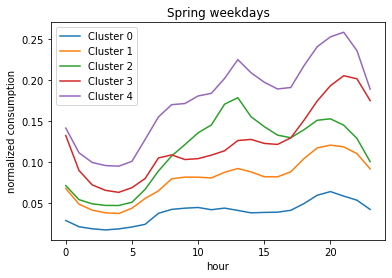

In [798]:
for x in range(0,5,1):
    plt.plot(clust_cent[x],label = "Cluster " + str(x))  
plt.legend()
plt.title("Spring weekdays")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

In [799]:
clust_coef = clust_coef.append(cluster_validation(kmeans_df,clustering),ignore_index = True)
clust_coef

,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,0.772570,5321.440256,0.381114
1,0.757771,5783.902924,0.402092
2,0.753033,5407.033738,0.406145
3,0.736585,4000.553603,0.422374
4,0.776643,6648.944497,0.357291


### Spring weekend days

In [800]:
red_df=df_sp_wknd[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

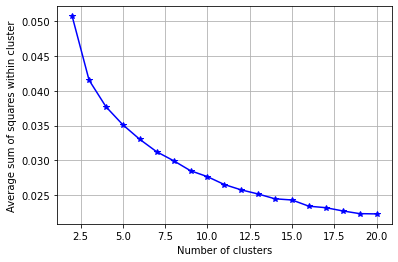

In [801]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [802]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [803]:
#reassign cluster numbers so the cluster numbers are from lowest to highest mean
k=5
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [804]:
#assign cluster labels odered by mean to dataframe
kmeans_df['cluster'] = list(lut[clustering.labels_])

In [805]:
#assign cluster membership to column of cluster_df
cluster_df["cluster_sp_wknd"] = kmeans_df['cluster']

In [806]:
#order clustering centers by mean
clust_cent = clustering.cluster_centers_[idx]

Text(0.5, 0, 'hour')

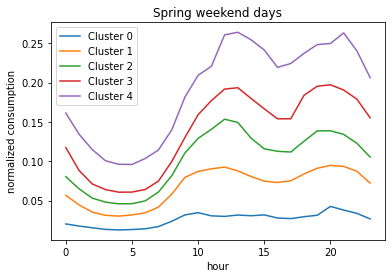

In [807]:
for x in range(0,5,1):
    plt.plot(clust_cent[x],label = "Cluster " + str(x))  
plt.legend()
plt.title("Spring weekend days")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

In [808]:
clust_coef = clust_coef.append(cluster_validation(kmeans_df,clustering),ignore_index = True)
clust_coef

,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,0.772570,5321.440256,0.381114
1,0.757771,5783.902924,0.402092
2,0.753033,5407.033738,0.406145
3,0.736585,4000.553603,0.422374
4,0.776643,6648.944497,0.357291
5,0.767521,5030.134319,0.370688


# Summer

### Summer weekdays

In [809]:
red_df=df_su_week[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

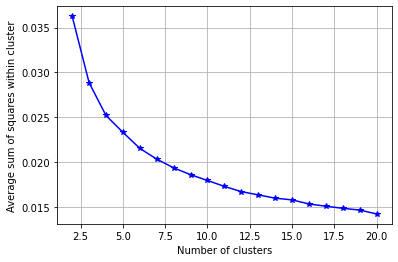

In [810]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [811]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [812]:
#reassign cluster numbers so the cluster numbers are from lowest to highest mean
k=5
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [813]:
#assign cluster labels odered by mean to dataframe
kmeans_df['cluster'] = list(lut[clustering.labels_])

In [814]:
#assign cluster membership to column of cluster_df
cluster_df["cluster_su_week"] = kmeans_df['cluster']

In [815]:
#order clustering centers by mean
clust_cent = clustering.cluster_centers_[idx]

Text(0.5, 0, 'hour')

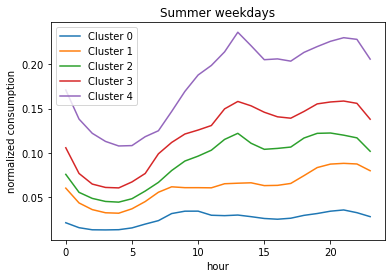

In [816]:
for x in range(0,5,1):
    plt.plot(clust_cent[x],label = "Cluster " + str(x))  
plt.legend()
plt.title("Summer weekdays")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

In [817]:
clust_coef = clust_coef.append(cluster_validation(kmeans_df,clustering),ignore_index = True)
clust_coef

,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,0.772570,5321.440256,0.381114
1,0.757771,5783.902924,0.402092
2,0.753033,5407.033738,0.406145
3,0.736585,4000.553603,0.422374
4,0.776643,6648.944497,0.357291
5,0.767521,5030.134319,0.370688
6,0.810571,7325.190893,0.308685


### Summer weekend days

In [818]:
red_df=df_su_wknd[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

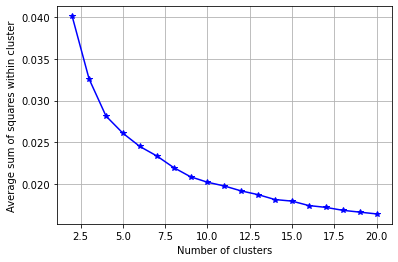

In [819]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [820]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [821]:
#reassign cluster numbers so the cluster numbers are from lowest to highest mean
k=5
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [822]:
#assign cluster labels odered by mean to dataframe
kmeans_df['cluster'] = list(lut[clustering.labels_])

In [823]:
#assign cluster membership to column of cluster_df
cluster_df["cluster_su_wknd"] = kmeans_df['cluster']

In [824]:
#order clustering centers by mean
clust_cent = clustering.cluster_centers_[idx]

Text(0.5, 0, 'hour')

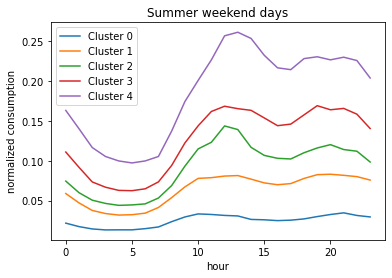

In [825]:
for x in range(0,5,1):
    plt.plot(clust_cent[x],label = "Cluster " + str(x))  
plt.legend()
plt.title("Summer weekend days")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

In [826]:
clust_coef = clust_coef.append(cluster_validation(kmeans_df,clustering),ignore_index = True)
clust_coef

,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,0.772570,5321.440256,0.381114
1,0.757771,5783.902924,0.402092
2,0.753033,5407.033738,0.406145
3,0.736585,4000.553603,0.422374
4,0.776643,6648.944497,0.357291
5,0.767521,5030.134319,0.370688
6,0.810571,7325.190893,0.308685
7,0.799351,6918.974862,0.326784


# Additional methods 

In [827]:
#kmeans_df['Fall_ge1'] = kmeans_df.index
#clusters_visualisation(kmeans_df, id_vars = ["Fall_ge1",'cluster'], value_vars = list(kmeans_df.columns[0:23]))
#plt.savefig('wknd_7_norm_year.png')

## Closer look at a cluster

In [828]:
# cl4_df = kmeans_df[kmeans_df["cluster"]==4]

In [829]:
# cl4_lst = list(cl4_df["Fall_ge1"].unique())
# cl4_lst

In [830]:
# df[df["Fall_ge1"].isin(cl4_lst)].loc["2010-05-02"].groupby("Fall_ge1").Electricity_Demand.plot()

In [831]:
# cl6_df = df[df["Fall_ge1"].isin(cl6_lst)]
# cl6_df["Daten_Herkunft"].unique()

# Connection with survey data 

In [832]:
survey = pd.read_csv("/Users/tamo/Documents/Studium/WS 20-21/Master thesis/Data/Intelliekon/survey1.csv")

In [833]:
descript = pd.read_csv("/Users/tamo/Documents/Studium/WS 20-21/Master thesis/Data/Intelliekon/survey1_descript.csv")

In [834]:
survey.ort.unique()

array(['Krefeld', 'Oelde', 'Schwerte', 'Ulm', 'Hassfurt',
       'Kaiserslautern', 'Celle', 'Münster', 'Linz'], dtype=object)

In [837]:
#Change of location
surv_id.Um_Auszug.value_counts()

0    567
1     33
Name: Um_Auszug, dtype: int64

<AxesSubplot:>

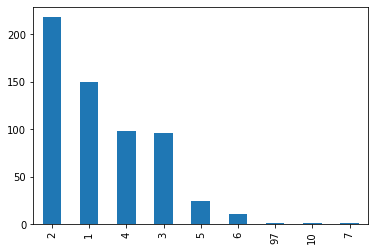

In [838]:
#number of residents
surv_id.q01.value_counts().plot(kind = "bar")

<AxesSubplot:ylabel='q01'>

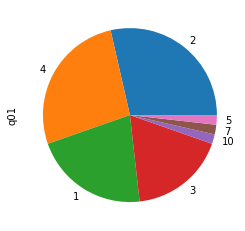

In [839]:
surv_id[surv_id["ort"] == "Schwerte"].q01.value_counts().plot(kind = "pie")

In [840]:
#Number of adults
surv_id.q01a1.value_counts()

2    348
1    167
3     63
4     17
5      4
6      1
Name: q01a1, dtype: int64

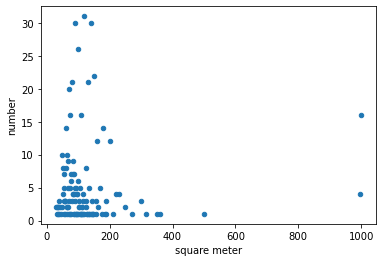

In [841]:
#Size of apartement
surv_id.s07.value_counts()
df_x = surv_id.s07.value_counts().to_frame()
df_x.reset_index(inplace=True)
df_x.columns = ['square meter','number']
df_x.plot(kind='scatter',x='square meter',y='number')
plt.show()

In [842]:
#Household income
surv_id.s08.value_counts()

09_Angabe verweigert             99
02_1.000 bis unter 1.500 Euro    84
03_1.500 bis unter 2.000 Euro    77
01_bis unter 1.000 Euro          68
04_2.000 bis unter 2.500 Euro    67
08_4.000 Euro und mehr           62
05_2.500 bis unter 3.000 Euro    55
06_3.000 bis unter 3.500 Euro    37
07_3.500 bis unter 4.000 Euro    28
10_weiß nicht                    23
Name: s08, dtype: int64

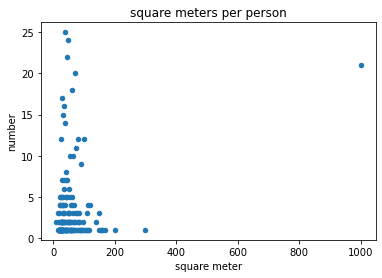

In [843]:
#Size of apartement per person
surv_id.s07pp.value_counts()
df_x = surv_id.s07pp.value_counts().to_frame()
df_x.reset_index(inplace=True)
df_x.columns = ['square meter','number']
df_x.plot(kind='scatter',x='square meter',y='number')
plt.title("square meters per person")
plt.show()

In [844]:
#Employment status
surv_id.ewstatus.value_counts()

01_berufstätig               352
02_nicht mehr berufstätig    170
04_Hausfrau/-mann             36
05_ohne Beschäftigung         22
03_in der Ausbildung          15
06_Antwort verweigert          4
07_weiß nicht                  1
Name: ewstatus, dtype: int64

In [845]:
surv_red = surv_id[["Fall_ge","ort","Um_Auszug","q01","q01a1","s07","s08","s07pp","ewstatus","berufst"]]
surv_red

,Fall_ge,ort,Um_Auszug,q01,q01a1,s07,s08,s07pp,ewstatus,berufst
0,1,Krefeld,0,1,1,140.0,10_weiß nicht,140.0,02_nicht mehr berufstätig,03_Haushalt ohne Berufstätige
1,2,Krefeld,0,2,2,160.0,09_Angabe verweigert,80.0,02_nicht mehr berufstätig,03_Haushalt ohne Berufstätige
2,3,Krefeld,0,2,2,200.0,04_2.000 bis unter 2.500 Euro,100.0,02_nicht mehr berufstätig,03_Haushalt ohne Berufstätige
3,4,Krefeld,0,2,2,52.0,10_weiß nicht,26.0,01_berufstätig,01_Haushalt mit Ganztagsberufstätigen
4,5,Krefeld,0,4,3,80.0,01_bis unter 1.000 Euro,20.0,01_berufstätig,01_Haushalt mit Ganztagsberufstätigen
...,...,...,...,...,...,...,...,...,...,...
625,1365,Münster,0,4,2,140.0,07_3.500 bis unter 4.000 Euro,35.0,01_berufstätig,01_Haushalt mit Ganztagsberufstätigen
626,1366,Münster,0,3,2,998.0,05_2.500 bis unter 3.000 Euro,999.0,01_berufstätig,01_Haushalt mit Ganztagsberufstätigen
627,1367,Münster,0,3,2,120.0,10_weiß nicht,40.0,01_berufstätig,01_Haushalt mit Ganztagsberufstätigen
628,1370,Münster,0,2,2,73.0,04_2.000 bis unter 2.500 Euro,36.5,03_in der Ausbildung,01_Haushalt mit Ganztagsberufstätigen


In [848]:
#funktion for plotting mean of different cities to compare them
def mean_plot_location (df,String):
    red_df=df[["hour","norm_energy","Daten_Herkunft"]]
    loc_lst=["Münster","Schwerte","Krefeld"]
    plt.plot(red_df.groupby("hour").mean(), label ="All locations")
    for loc in loc_lst:
        loc_df = red_df[red_df["Daten_Herkunft"]== loc].groupby("hour").mean()
        plt.plot(loc_df, label = loc)
    plt.legend()
    plt.title(String + " mean of diffeerent locations")

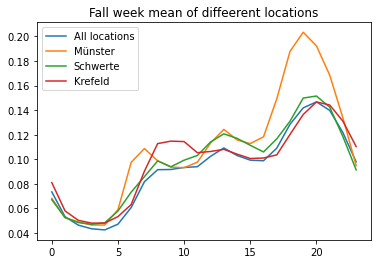

In [849]:
mean_plot_location(df_fa_week,"Fall week")

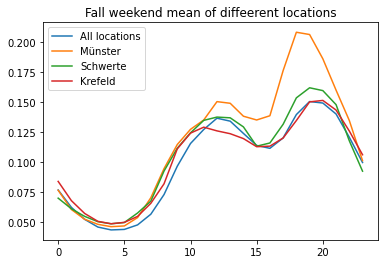

In [850]:
mean_plot_location(df_fa_wknd,"Fall weekend")

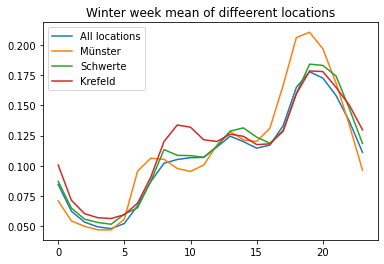

In [851]:
mean_plot_location(df_wi_week,"Winter week")

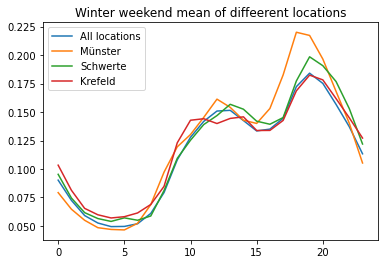

In [852]:
mean_plot_location(df_wi_wknd, "Winter weekend")

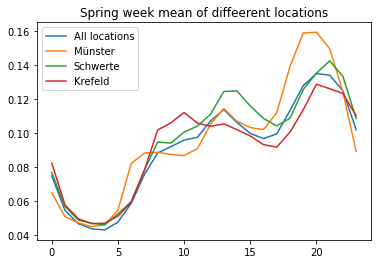

In [853]:
mean_plot_location(df_sp_week, "Spring week")

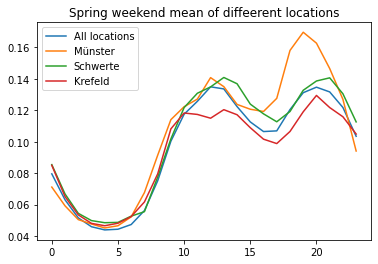

In [854]:
mean_plot_location(df_sp_wknd, "Spring weekend")

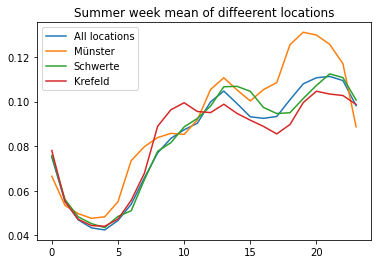

In [855]:
mean_plot_location(df_su_week, "Summer week")

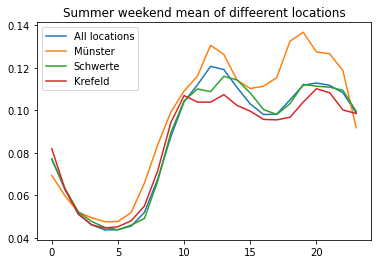

In [856]:
mean_plot_location(df_su_wknd, "Summer weekend")

<AxesSubplot:ylabel='s03a'>

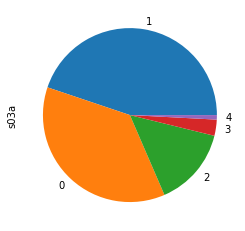

In [857]:
#Size of apartement per person
surv_id.s03a.value_counts().plot(kind="pie")


In [881]:
def survey_connection (df_surv,location):
    
    df_surv = df_surv[df_surv["ort"] == location]
    #number of residents
    num_res = df_surv[df_surv["q01"]<= 10].q01.value_counts().sort_index()
    #number of adults
    num_adlt = df_surv[df_surv["q01a1"]<= 10].q01a1.value_counts().sort_index()
    #number of full-time working residents
    num_full = df_surv.s03a.value_counts().sort_index()
    #number of half-time working residents
    num_half = df_surv.s03b.value_counts().sort_index() 
    
    fig, axs = plt.subplots(1, 4, figsize=(14, 6))
    #number of residents as pie plot
    num_res.plot(ax=axs[0], kind = "pie",title = "Number of residents")
    #number of residents as pie plot
    num_adlt.plot(ax=axs[1], kind = "pie",title = "Adult residents")
    num_full.plot(ax=axs[2], kind = "pie",title = "Full-time working residents")
    num_half.plot(ax=axs[3], kind = "pie",title = "Half-time working residents")
    
    fig.suptitle('Plotting of categorical variables of ' + location)
    

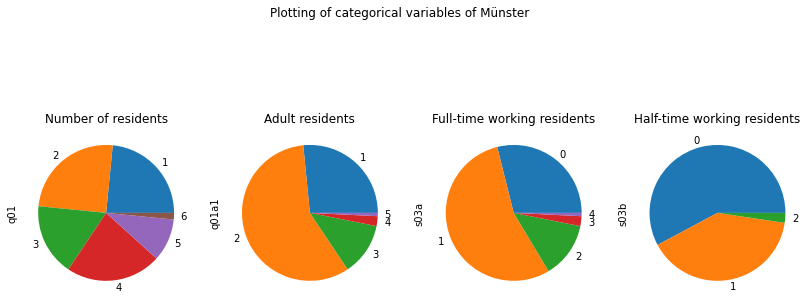

In [882]:
survey_connection (surv_id,"Münster")

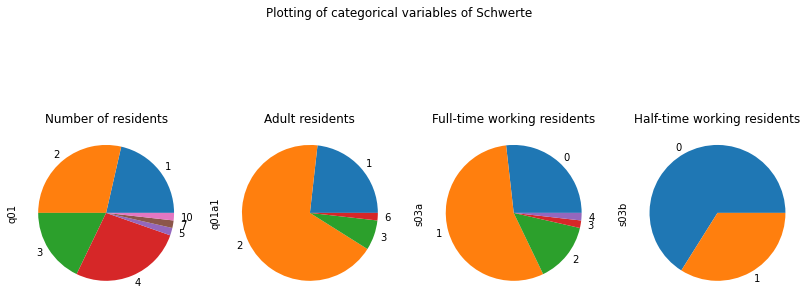

In [883]:
survey_connection (surv_id,"Schwerte")

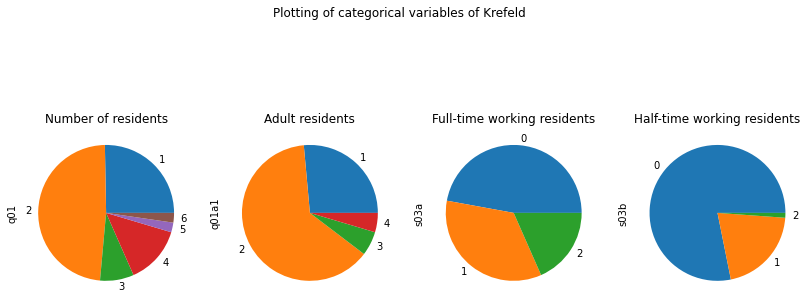

In [884]:
survey_connection (surv_id,"Krefeld")